In [1]:
import xspec
import numpy as np
import matplotlib.pyplot as plot
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [4]:
xspec.AllData("spec_grp_1.pi")
xspec.Plot("data")
xspec.Plot.xAxis = "keV"

x_values = xspec.Plot.x()
y_values = xspec.Plot.y()
y_error = np.array(xspec.Plot.yErr())
x_error = np.array(xspec.Plot.xErr())


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.098e-01 +/- 4.637e-02 (91.2 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-282
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 209.2 sec
 Using fit statistic: chi
 Using Background File                ./en01_079066_020_BackgrSpec_00008_c010.fits
  Background Exposure Time: 209.2 sec
 Using Response (RMF) File            ./en01_079066_020_RMF_00008_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./en01_079066_020_ARF_00008_c010.fits



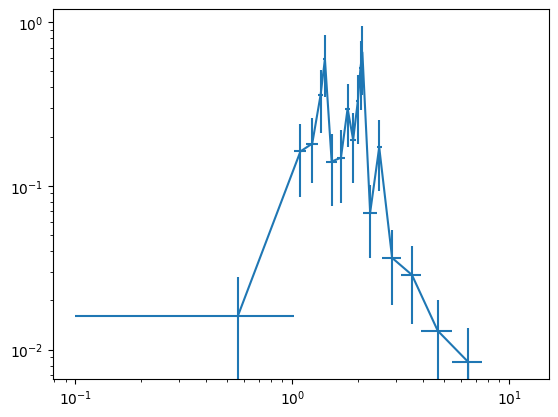

In [5]:
plot.errorbar(x_values,y_values,xerr = x_error, yerr = y_error)
plot.xscale("log")
plot.yscale("log")

In [6]:
#Column Stacking X and Removing negative and zero counts
x = np.log10(x_values)
y = y_values

X1 = np.column_stack((x,y))
X = []
for i in X1:
    if i[-1] != 0 and np.all(i > 0):  
        X.append(i)
        #y_val = np.array(y_val)
X= np.array(X)

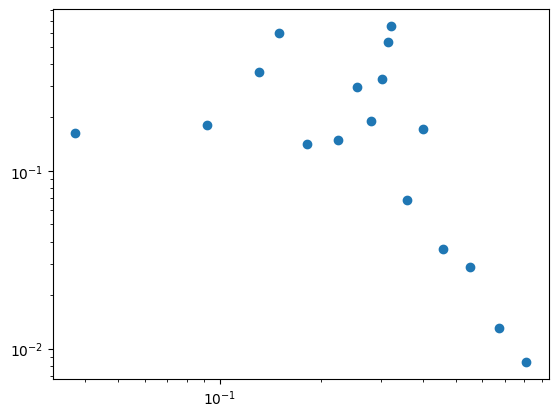

In [7]:
#Plotting the final plot
energy =  X[:,0]
counts = X[:,1]
plot.scatter(energy,counts)
plot.xscale("log")
plot.yscale("log")

In [8]:
##Doing interpolation to find Ep through minimization 
f = interp1d(energy,counts, kind = "cubic", fill_value="extrapolate")

def f1(x):
    if energy.min() <= x <= energy.max():  
        return -f(x)

Ep = minimize(f1,x0 = 0.3,method = "Nelder-Mead").x[0]
Cp = f(Ep)
Ep, Cp

(0.3258984375, array(0.66535981))

In [11]:
#Fitting model (broken Power law) and initial parameters
model = xspec.Model("bknpower")

#initiate params
model.bknpower.PhoIndx1 = 0.5
model.bknpower.BreakE = Ep
model.bknpower.PhoIndx2 = 2 
model.bknpower.norm = 2.00
model.bknpower.BreakE.frozen = True
#model.bknpower.norm.frozen = True


Model bknpower<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   bknpower   PhoIndx1            1.00000      +/-  0.0          
   2    1   bknpower   BreakE     keV      5.00000      +/-  0.0          
   3    1   bknpower   PhoIndx2            2.00000      +/-  0.0          
   4    1   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              6.307021e+09     using 282 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared              6.307021e+09     using 282 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 278 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared             

In [12]:
xspec.Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl    1:PhoIndx1    3:PhoIndx2        4:norm
203.605      0.615987      0      0.372418       1.25893   8.66911e-05
202.918      1836.45       0      0.320453      0.951232   8.23219e-05
202.898      1182.21       0      0.316289      0.984944   8.24637e-05
202.898      60.3937       0      0.311302      0.978888   8.25590e-05
 Variances and Principal Axes
                 1        3        4  
 7.2839E-10|  0.0001  -0.0001   1.0000  
 6.2528E-01| -0.0123  -0.9999  -0.0001  
 1.0401E+04|  0.9999  -0.0123  -0.0001  
----------------------------------------

  Covariance Matrix
        1           2           3   
   1.040e+04  -1.278e+02  -9.830e-01
  -1.278e+02   2.195e+00   1.212e-02
  -9.830e-01   1.212e-02   9.292e-05
------------------------------------

Model bknpower<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   bknpower   PhoIndx1            0.311302    

In [14]:
# Print parameter values
print("Photon Index1:", model.bknpower.PhoIndx1.values[0])
print("Photon Index2:", model.bknpower.PhoIndx2.values[0])
print("Ep:",Ep,"keV")

Photon Index1: 0.31130169870750773
Photon Index2: 0.9788880433336119
Ep: 0.3258984375 keV


In [15]:
#Plotting
xspec.Plot.device = "/xs" 
xspec.Plot("data model")

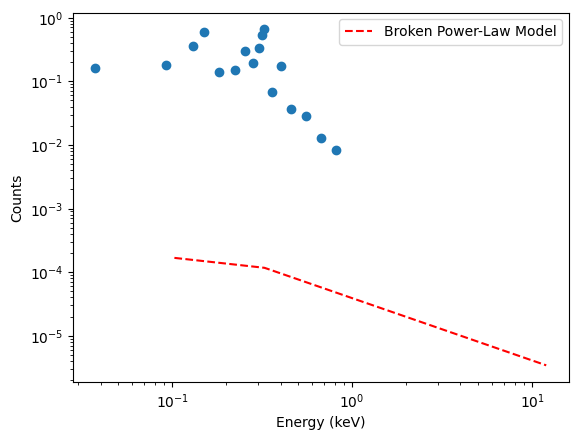

In [16]:
# Extract data from XSPEC
xspec.Plot("model")  # Load model
model_x = np.array(xspec.Plot.x())   
model_y = np.array(xspec.Plot.model())  

#Create a log-log plot
plot.scatter(energy, counts)
plot.plot(model_x, model_y, label="Broken Power-Law Model", color='red', linestyle='--')
plot.xscale("log")
plot.yscale("log")
plot.xlabel("Energy (keV)")
plot.ylabel("Counts")
plot.legend()